In [14]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams

import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

from xgboost import XGBRegressor


In [15]:
import optuna

file_path = '../cleaned_data2.csv'  # <-- แก้เอง

# Use existing df_all in the notebook if available, otherwise read CSV
if 'df_all' in globals():
    df_all_local = df_all.copy()
    print("Using existing df_all from notebook variables")
else:
    df_all_local = pd.read_csv(file_path)
    print(f"Loaded df_all from {file_path}")

# If the dataset is in long format (date_month, ind_code, value) pivot to wide.
# If it's already wide (like the provided cleaned_data2.csv), skip pivot.
if 'ind_code' in df_all_local.columns and 'value' in df_all_local.columns:
    # ensure date column name matches expectation
    if 'date_month' not in df_all_local.columns and 'year_month' in df_all_local.columns:
        df_all_local = df_all_local.rename(columns={'year_month': 'date_month'})
    # ลบ whitespace จาก ind_code
    df_all_local['ind_code'] = df_all_local['ind_code'].astype(str).str.strip()

    print("Available indicators:")
    print(sorted(df_all_local['ind_code'].unique()))
    print()

    df = df_all_local.pivot_table(
        index='date_month',
        columns='ind_code',
        values='value'
    ).reset_index()
else:
    # assume wide format; try to find date column
    if 'date_month' in df_all_local.columns:
        df = df_all_local.copy()
        date_col = 'date_month'
    elif 'year_month' in df_all_local.columns:
        df = df_all_local.copy().rename(columns={'year_month': 'date_month'})
        date_col = 'date_month'
    else:
        raise KeyError("No 'ind_code' column and no recognized date column ('date_month' or 'year_month') found in df_all.")

    print(f"Data treated as wide format. Columns: {sorted(df.columns.tolist())}\n")

print(f"Data loaded: {df.shape}")

# เตรียมข้อมูล
df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month']).sort_index()
df = df.asfreq('MS')  # ตั้งความถี่เป็น Monthly Start

print("Data preparation completed\n")
df.info()

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df


Loaded df_all from ../cleaned_data2.csv
Data treated as wide format. Columns: ['china_pmi', 'china_pmi_lag12', 'china_pmi_lag6', 'china_pmi_ma12', 'china_pmi_ma6', 'china_pmi_std12', 'china_pmi_std6', 'date_month', 'domestic_consumption', 'exchange_rate_usd', 'exchange_rate_usd_pct12', 'exchange_rate_usd_pct6', 'export_volume', 'import_volume', 'is_season', 'month', 'oil_price_thb', 'oil_price_thb_lag12', 'oil_price_thb_lag6', 'oil_price_thb_ma12', 'oil_price_thb_ma6', 'oil_price_thb_pct12', 'oil_price_thb_pct6', 'oil_price_thb_std12', 'oil_price_thb_std6', 'quarter', 'stock', 'stock_lag12', 'stock_lag6', 'thai_price', 'thai_price_lag12', 'thai_price_lag6', 'thai_price_ma12', 'thai_price_ma6', 'thai_price_pct12', 'thai_price_pct6', 'thai_price_std12', 'thai_price_std6', 'world_price_thb_kg', 'world_price_thb_kg_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_std12', 'world

C:\Users\bankw\AppData\Local\Temp\ipykernel_44352\4284123914.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,thai_price,oil_price_thb,world_price_thb_kg,month,...,china_pmi_ma12,china_pmi_std12,thai_price_pct6,thai_price_pct12,world_price_thb_kg_pct6,world_price_thb_kg_pct12,oil_price_thb_pct6,oil_price_thb_pct12,exchange_rate_usd_pct6,exchange_rate_usd_pct12
date_month,,,,,,,,,,,,,,,,,,,,,
2007-01-01,30652000,55000,267567000.0,2.806710e+08,36.1800,54.8,65.12,2103.505200,75.168260,1,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-02-01,26790000,44000,237979000.0,2.490050e+08,35.7500,55.1,72.91,2208.992500,81.465325,2,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-03-01,31717000,119000,230410000.0,2.173390e+08,35.0600,53.1,69.62,2309.402200,78.626062,3,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-04-01,27788000,184000,180185000.0,1.785750e+08,34.8700,56.1,72.84,2291.307700,80.907121,4,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-05-01,32905000,91000,178103000.0,2.092150e+08,34.6200,58.6,71.47,2216.026200,82.004049,5,...,54.991667,1.568704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-01,109368000,63000,369222000.0,1.050152e+09,33.9385,50.2,67.91,2367.549760,82.482469,2,...,49.858333,0.541812,-4.927901,-0.556450,-0.770023,10.757094,-7.819097,-16.007660,-2.810989,-5.773502
2025-03-01,95398000,111000,369396000.0,9.991970e+08,33.9768,50.5,66.56,2428.661664,81.367993,3,...,49.833333,0.499697,-15.274949,-16.591479,-10.363973,-10.362344,6.261304,-19.139439,1.340698,-5.915321
2025-04-01,69306000,73000,317716000.0,8.799700e+08,33.9148,49.0,59.69,1974.180508,73.920391,4,...,49.716667,0.518448,-21.789832,-22.288764,-16.509908,-15.814324,-14.981222,-34.788767,1.157887,-8.215834


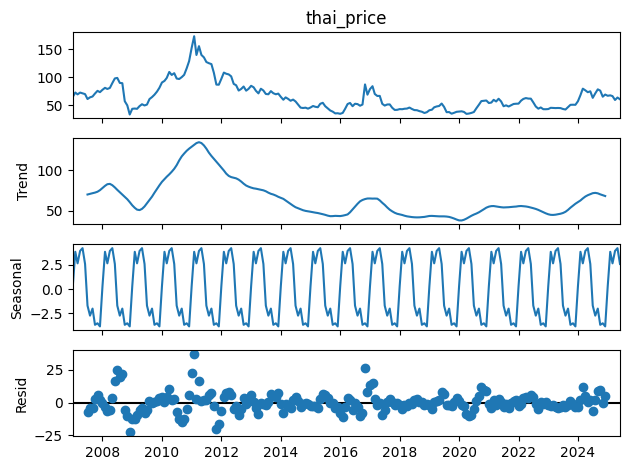

In [16]:
result = seasonal_decompose(df['thai_price'], model='additive', period=12)
result.plot()
plt.show()


Available columns: ['domestic_consumption', 'import_volume', 'export_volume', 'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price', 'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year', 'is_season', 'thai_price_lag6', 'thai_price_lag12', 'world_price_thb_kg_lag6', 'world_price_thb_kg_lag12', 'oil_price_thb_lag6', 'oil_price_thb_lag12', 'china_pmi_lag6', 'china_pmi_lag12', 'stock_lag6', 'stock_lag12', 'thai_price_ma6', 'thai_price_std6', 'thai_price_ma12', 'thai_price_std12', 'world_price_thb_kg_ma6', 'world_price_thb_kg_std6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_std12', 'oil_price_thb_ma6', 'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12', 'china_pmi_ma6', 'china_pmi_std6', 'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct6', 'thai_price_pct12', 'world_price_thb_kg_pct6', 'world_price_thb_kg_pct12', 'oil_price_thb_pct6', 'oil_price_thb_pct12', 'exchange_rate_usd_pct6', 'exchange_rate_usd_pct12']
Selected external factors: ['world_price_thb

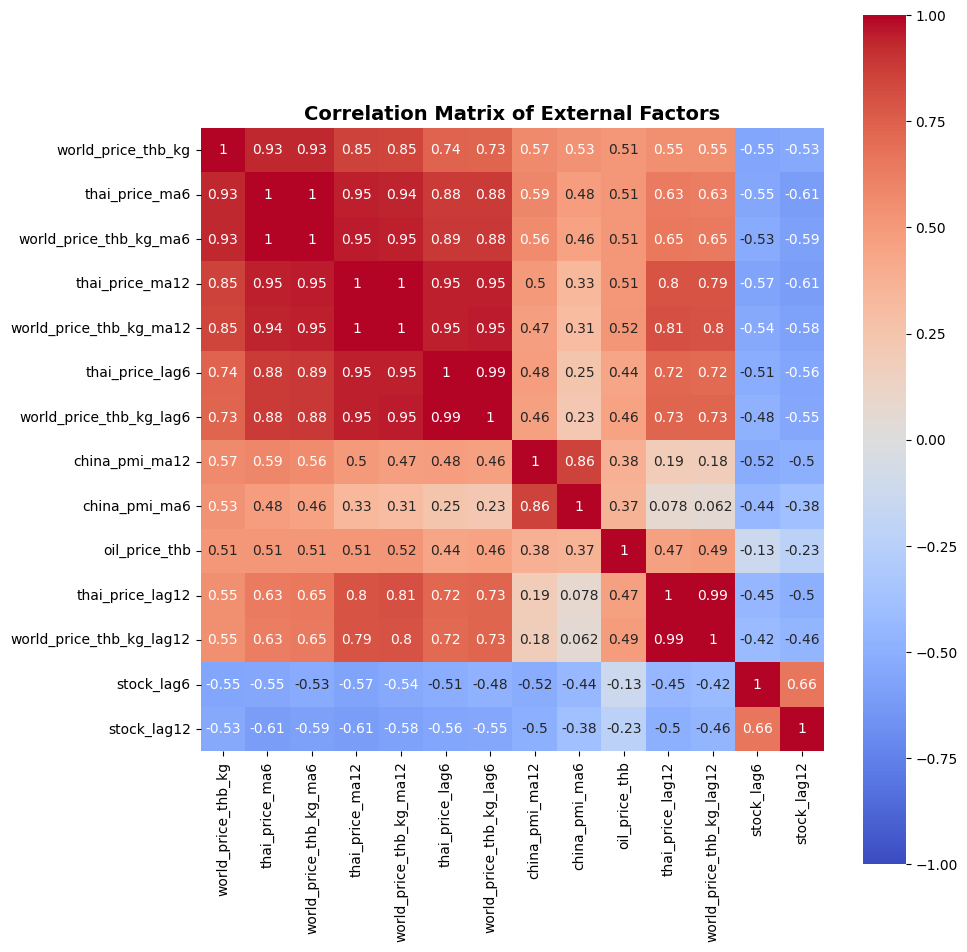

In [17]:
external_factors = [
    'world_price_thb_kg', 'thai_price_ma6', 'world_price_thb_kg_ma6', 'thai_price_ma12', 'world_price_thb_kg_ma12', 'thai_price_lag6', 'world_price_thb_kg_lag6',
    'china_pmi_ma12', 'china_pmi_ma6', 'oil_price_thb', 'thai_price_lag12', 'world_price_thb_kg_lag12', 'stock_lag6', 'stock_lag12'
]

print("Available columns:", df.columns.tolist())
print("Selected external factors:", [c for c in external_factors if c in df.columns])
print()

# เตรียม X, y
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

X_train = train_exog.copy()
X_test  = test_exog.copy()
y_train = train_data['thai_price']
y_test  = test_data['thai_price']

mean_trp = y_train.mean()
print(f"Mean thai_price (train): {mean_trp:.4f}")
print("X_train:", X_train.shape, " X_test:", X_test.shape)

# Correlation matrix ของ external factors
corr = train_exog.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title("Correlation Matrix of External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [18]:
before_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
before_model.fit(X_train, y_train)
pred_before = before_model.predict(X_test)

rmse_before = np.sqrt(mean_squared_error(y_test, pred_before))
mape_before = mean_absolute_percentage_error(y_test, pred_before)*100

print("=== BEFORE MODEL ===")
print("RMSE:", rmse_before)
print("MAPE:", mape_before)


=== BEFORE MODEL ===
RMSE: 3.344517037561506
MAPE: 4.0571481168616135


In [19]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "gamma": trial.suggest_float("gamma", 0, 0.3),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10),
        "random_state": 44
    }

    model = XGBRegressor(**params, objective='reg:squarederror')
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    return mean_squared_error(y_test, pred, squared=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60)

best_params = study.best_params
print("\nBest Params:", best_params)


[I 2025-11-26 22:54:10,295] A new study created in memory with name: no-name-d1d9b57f-40c9-452f-b81a-c816c7378443
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-11-26 22:54:10,448] Trial 0 finished with value: 9.388053124650291 and parameters: {'n_estimators': 271, 'learning_rate': 0.06288689482551436, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.09948182065210655, 'subsample': 0.08653784419725014, 'colsample_bytree': 0.18664665274722742, 'reg_alpha': 0.359490873202576, 'reg_lambda': 0.588383654584545}. Best is trial 0 with value: 9.388053124650291.
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in


Best Params: {'n_estimators': 223, 'learning_rate': 0.057453963919178, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.2652056274502905, 'subsample': 0.5832720884910932, 'colsample_bytree': 0.9573938778721921, 'reg_alpha': 0.317525699246245, 'reg_lambda': 1.0645704875072848}


In [20]:
after_model = XGBRegressor(
    **best_params, objective='reg:squarederror'
)

after_model.fit(X_train, y_train)
pred_after = after_model.predict(X_test)

rmse_after = np.sqrt(mean_squared_error(y_test, pred_after))
mape_after = mean_absolute_percentage_error(y_test, pred_after)*100

print("=== AFTER MODEL (Optuna) ===")
print("RMSE:", rmse_after)
print("MAPE:", mape_after)


=== AFTER MODEL (Optuna) ===
RMSE: 3.2162095227580756
MAPE: 4.119025323871886


In [21]:
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    nrmse = rmse / mean_trp
    mape_norm = mape / 100
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return score

score_before = compute_score(rmse_before, mape_before, mean_trp)
score_after  = compute_score(rmse_after, mape_after, mean_trp)

print("\n=== SCORE ===")
print("Before:", score_before)
print("After :", score_after)



=== SCORE ===
Before: 95.38186298094412
After : 95.45026918094074


In [22]:
comparison_df = pd.DataFrame({
    "Model": ["Before", "After (Optuna)"],
    "RMSE": [rmse_before, rmse_after],
    "MAPE (%)": [mape_before, mape_after],
    "Score": [score_before, score_after]
})

print("\n=== COMPARISON TABLE ===")
print(comparison_df.to_string(index=False))



=== COMPARISON TABLE ===
         Model     RMSE  MAPE (%)     Score
        Before 3.344517  4.057148 95.381863
After (Optuna) 3.216210  4.119025 95.450269


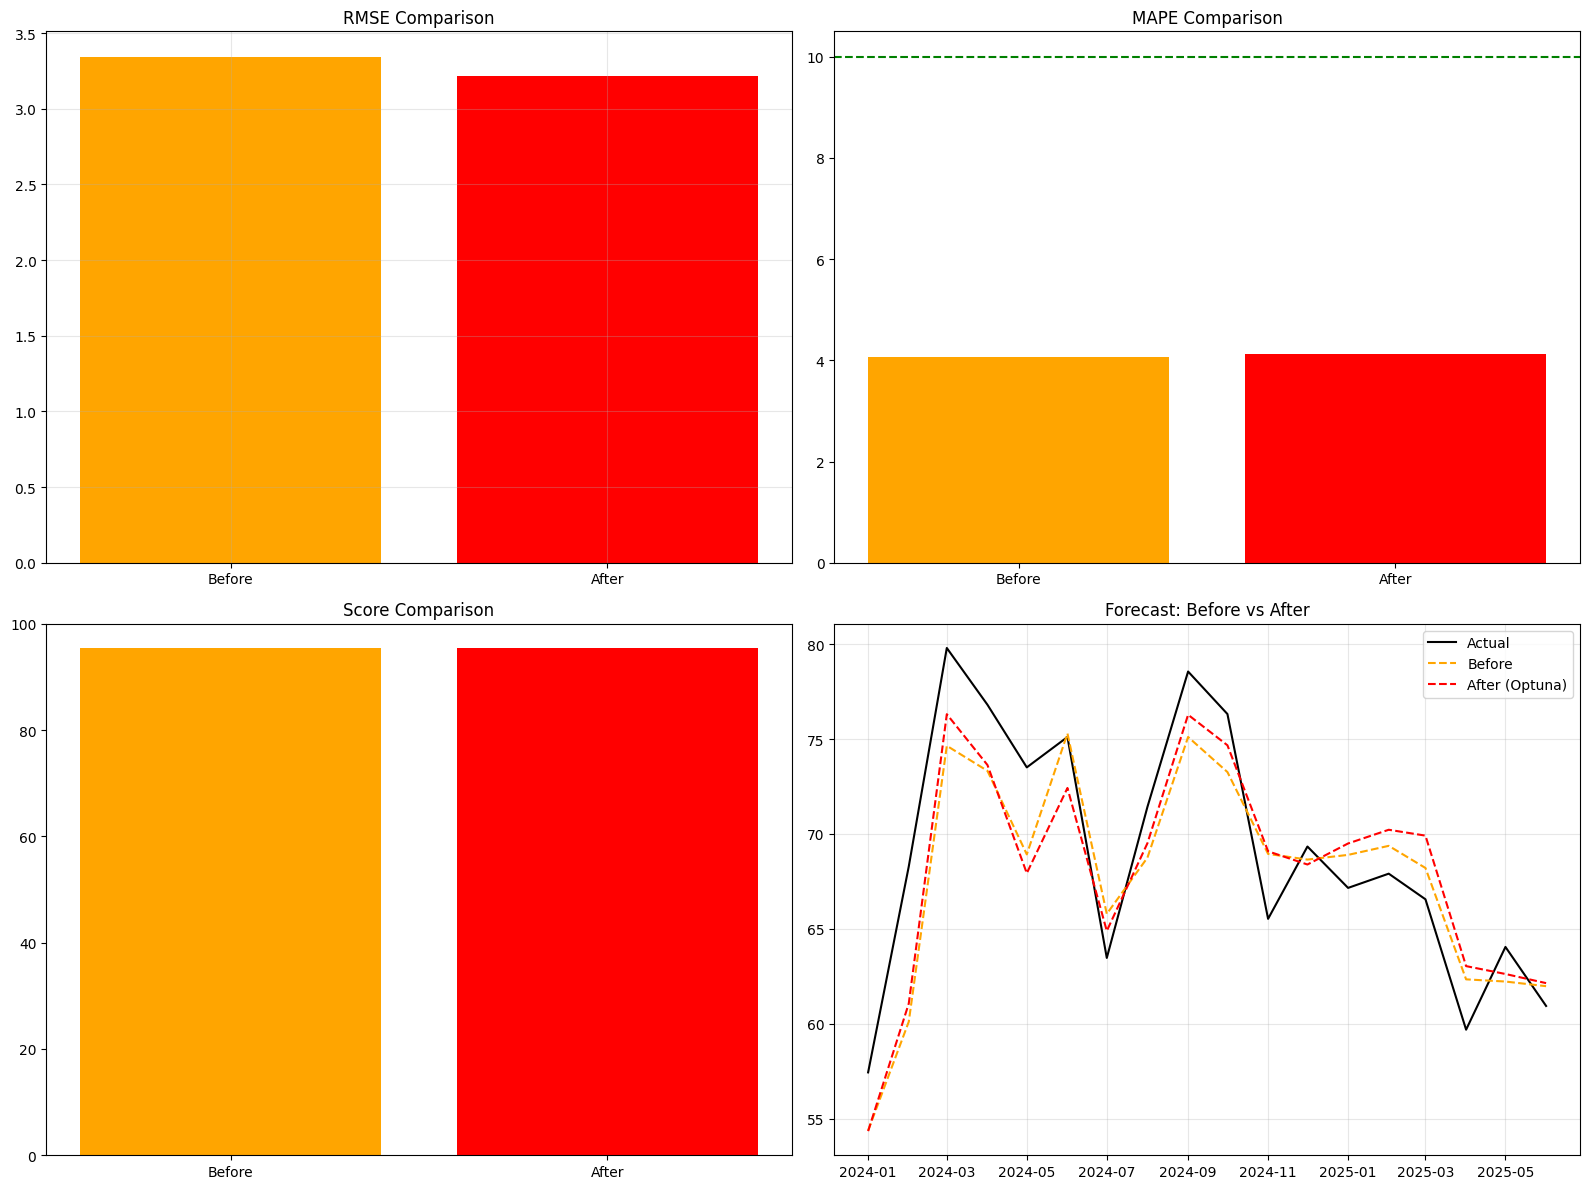

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE
axes[0, 0].bar(["Before", "After"], [rmse_before, rmse_after], color=['orange','red'])
axes[0, 0].set_title("RMSE Comparison")
axes[0, 0].grid(True, alpha=0.3)

# MAPE
axes[0, 1].bar(["Before", "After"], [mape_before, mape_after], color=['orange','red'])
axes[0, 1].set_title("MAPE Comparison")
axes[0, 1].axhline(10, color='green', linestyle='--')

# Score
axes[1, 0].bar(["Before", "After"], [score_before, score_after], color=['orange','red'])
axes[1, 0].set_ylim(0, 100)
axes[1, 0].set_title("Score Comparison")

# Forecast
axes[1, 1].plot(y_test.index, y_test.values, label="Actual", color='black')
axes[1, 1].plot(y_test.index, pred_before, label="Before", linestyle='--', color='orange')
axes[1, 1].plot(y_test.index, pred_after, label="After (Optuna)", linestyle='--', color='red')
axes[1, 1].set_title("Forecast: Before vs After")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


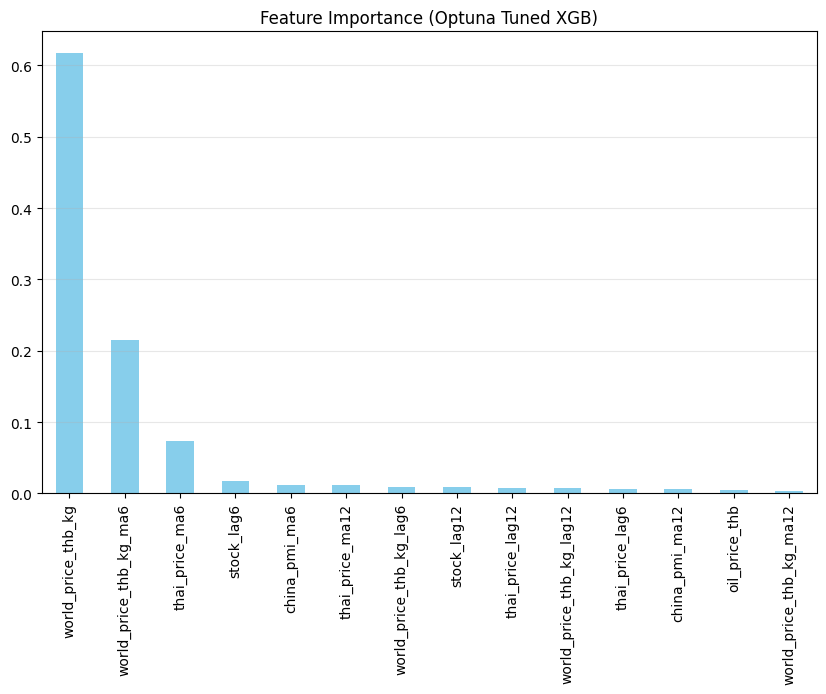

In [24]:
importances = pd.Series(after_model.feature_importances_, index=X_train.columns)\
                .sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance (Optuna Tuned XGB)")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [25]:
data = {
    'Model': ['Before (Fixed XGB)', 'After (Optuna Tuned)'],
    'RMSE': [rmse_before, rmse_after],
    'MAPE': [mape_before/100, mape_after/100],
    'ACCURACY': [score_before/100, score_after/100]
}

df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)
df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison\n")
print(df_display.to_string(index=True, col_space=12))


Performance Comparison

                             Model         RMSE     MAPE (%) ACCURACY (%)
0               Before (Fixed XGB)     3.344517        4.06%       95.38%
1             After (Optuna Tuned)     3.216210        4.12%       95.45%
